In [15]:
from datetime import datetime

import numpy as np
from torch.utils.data import DataLoader

from prediction.data import AISDataSet, vessel_groups
from prediction.evaluation import frechet_distance, hausdorff_distance
from prediction.model import BaselineModel
from prediction.preprocessing import haversine_tensor, load_and_build

MIN_POINTS = 100
N_PRED = 80
BATCH_SIZE = 512

In [16]:
groups = vessel_groups()
df = load_and_build(
    datetime(2024, 1, 1), datetime(2024, 1, 2), min_points=MIN_POINTS, vessel_groups=groups, n_processes=2
)
len(df)

Loading and building trajectories for 2 days using 2 processes
Loading and building trajectories for 2024-01-02 00:00:00
Loading and building trajectories for 2024-01-01 00:00:00


100%|██████████| 14868/14868 [02:14<00:00, 110.41it/s]


24150

In [17]:
model = BaselineModel(pred_len=N_PRED)
dataset = AISDataSet(
    df, n_pred=N_PRED, seq_len=10, include_speed=False, include_orientation=False, include_timestamps=False
)
loader = DataLoader(dataset, batch_size=BATCH_SIZE)

100%|██████████| 2195/2195 [00:00<00:00, 2220.98it/s]


In [18]:
frechets, haversines, hausdorffs = [], [], []
for x, y in loader:
    y_pred = model(x)
    frechets.extend(frechet_distance(y, y_pred).cpu().detach().tolist())
    hausdorffs.extend(hausdorff_distance(y, y_pred).cpu().detach().tolist())
    haversines.extend(haversine_tensor(y, y_pred, tensor_reduction=None).cpu().detach().tolist())

frechets = np.array(frechets)
hausdorffs = np.array(hausdorffs)
haversines = np.array(haversines)

print(f"Frechet: {frechets.mean():.4f}")
print(f"Hausdorff: {hausdorffs.mean():.4f}")
print(f"Haversine: {haversines.mean():.4f}")

/Users/marcus/Documents/Workspace/python-envs/ais-env/lib/python3.11/site-packages/shapely/measurement.py:218: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)


Frechet: 0.1282
Hausdorff: 0.1234
Haversine: 264.9385


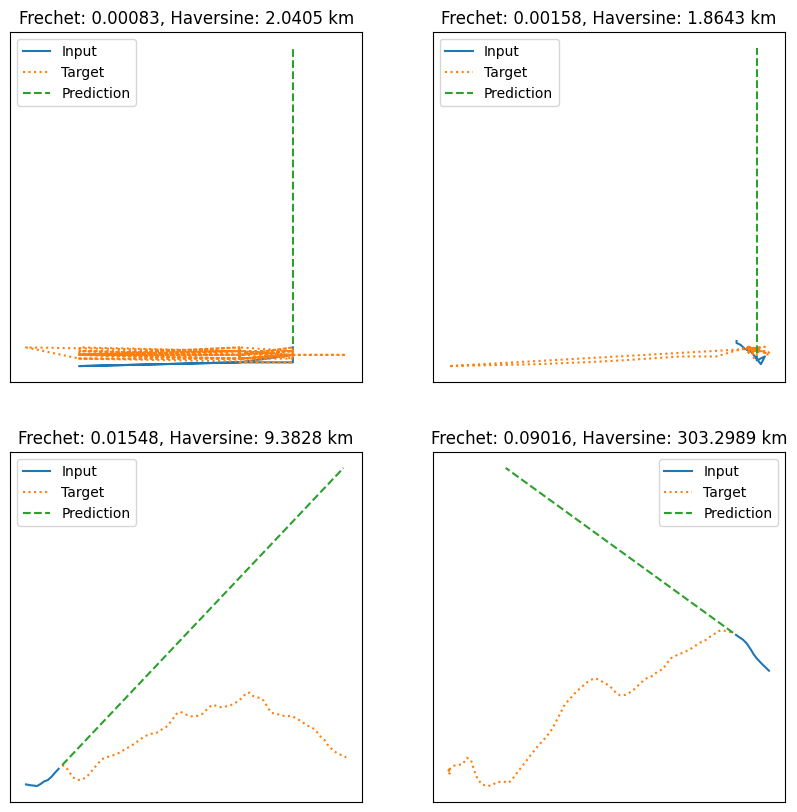

In [25]:
import matplotlib.pyplot as plt

plot_loader = DataLoader(dataset, batch_size=1, shuffle=True)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i, (x, y) in enumerate(plot_loader):
    y_pred = model(x)
    haversine = haversine_tensor(y, y_pred).cpu().detach().item()
    frechet = frechet_distance(y, y_pred, reduction=None).cpu().detach().item()

    row = i // 2
    col = i % 2

    x = x[0].detach().numpy()
    y = y[0].detach().numpy()

    ax[row, col].plot(x[:, 0], x[:, 1], label='Input')
    ax[row, col].plot(y[:, 0], y[:, 1], label='Target', linestyle='dotted')
    ax[row, col].plot(
        y_pred[0].detach().numpy()[:, 0], y_pred[0].detach().numpy()[:, 1], label='Prediction', linestyle='--'
    )
    ax[row, col].legend()
    ax[row, col].set_title(f'Frechet: {frechet:.5f}, Haversine: {haversine:.4f} km')
    # remove ticks
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])

    if i == 3:
        break

plt.show()